<p>The data is available as two attached CSV files:</p>
<p>takehome_user_engagement. csv</p>
<p>takehome_users . csv</p>
<p>The data has the following two tables:</p>
<p>1] A user table ( "takehome_users" ) with data on 12,000 users who signed up for the
product in the last two years. This table includes:</p>
<p>● name: the user's name</p>
<p>● object_id: the user's id</p>
<p>● email: email address</p>
<p>● creation_source: how their account was created. This takes on one
of 5 values:</p>
<p>○ PERSONAL_PROJECTS: invited to join another user's
personal workspace</p>
<p>○ GUEST_INVITE: invited to an organization as a guest
(limited permissions)</p>
<p>○ ORG_INVITE: invited to an organization (as a full member)</p>
<p>○ SIGNUP: signed up via the website</p>
<p>○ SIGNUP_GOOGLE_AUTH: signed up using Google
Authentication (using a Google email account for their login
id)</p>
<p>● creation_time: when they created their account</p>
<p>● last_session_creation_time: unix timestamp of last login</p>
<p>● opted_in_to_mailing_list: whether they have opted into receiving
marketing emails</p>
<p>● enabled_for_marketing_drip: whether they are on the regular
marketing email drip</p>
<p>● org_id: the organization (group of users) they belong to</p>
<p>● invited_by_user_id: which user invited them to join (if applicable).</p>
<p>2] A usage summary table ( "takehome_user_engagement" ) that has a row for each day
that a user logged into the product.
Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday
period , identify which factors predict future user
adoption .</p>
<p>We suggest spending 1-2
hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better no
more
than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.</p>

In [85]:
import pandas as pd
import numpy as np
import warnings
import forest_ensembles
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

ModuleNotFoundError: No module named 'requirements'

In [2]:
#reading in data
engagement = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv')
engagement.head()

,time_stamp,user_id,visited
0,4/22/2014 3:53,1,1
1,11/15/2013 3:45,2,1
2,11/29/2013 3:45,2,1
3,12/9/2013 3:45,2,1
4,12/25/2013 3:45,2,1


<div class="span5 alert alert-info">
<ul>
The following 4 cells just explore the data to see what type of format the data is in and whether it has any missing data
</ul>
</div>



In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
print(engagement.info())
engagement.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [5]:
print(users.info())
users.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [6]:
# converting timestamp to datetime
engagement['time_stamp'] = engagement['time_stamp'].astype('datetime64[ns]') 

In [7]:
#grouping by user_id and the time to see the number of times each visitor logged in; however, this was not
# too helpful as none of the users logged in more than one day in a row.
engagement_grouped = engagement.groupby(['user_id','time_stamp']).sum()
engagement_grouped.head(20)

visited
user_id time_stamp                  
1       2014-04-22 03:53:00        1
2       2013-11-15 03:45:00        1
        2013-11-29 03:45:00        1
        2013-12-09 03:45:00        1
        2013-12-25 03:45:00        1
        2013-12-31 03:45:00        1
        2014-01-08 03:45:00        1
        2014-02-03 03:45:00        1
        2014-02-08 03:45:00        1
        2014-02-09 03:45:00        1
        2014-02-13 03:45:00        1
        2014-02-16 03:45:00        1
        2014-03-09 03:45:00        1
        2014-03-13 03:45:00        1
        2014-03-31 03:45:00        1
3       2013-03-19 23:14:00        1
4       2013-05-22 08:09:00        1
5       2013-01-22 10:14:00        1
6       2013-12-19 03:37:00        1
7       2012-12-20 13:24:00        1

<div class="span5 alert alert-info">
<ul>
The function in the next cell prepares the data so that I can figure out how long between each login of the user in number of days. This prepares the data for the following for loop that will determine whether the user is an "adopted user" meaning that they logged into the product 3 times in a 7 day period. 
</ul>
</div>

In [8]:
from collections import defaultdict
def activity_fx(df):
    """ This function dakes a dataframe with user id's and finds the difference in time between each login
    that the user had in the number of days. 
    """
    user_deltas = defaultdict(list)
    for user in df.user_id.unique(): #only looking at the unique user_ids so we don't have duplicates
        # next a dataframe that only has a single users' login timestamps
        userlogins = df[df.user_id == user] 
        userlogins2 = userlogins.set_index('time_stamp')
        deltas = []
        if len(userlogins2) > 2: # must be greater than 2 logins since they have to be 3 days in a 7 day period
            for d in range(1,len(userlogins2.index)-1):
                #timedelta between the next timestamp and the current timestamp
                delta = userlogins2.index[d+1]-userlogins2.index[d] 
                deltas.append(delta.days) #put the number of timestamp deltas into a blank list
        user_deltas[user]=deltas #attach the list to the user_id as a key in the defaultdict
    return(user_deltas) #dictionary with user_ids attached to their login deltas
deltas = activity_fx(engagement)   

In [9]:
adopted_user = defaultdict(bool)
for key,value in deltas.items():
    if len(value)>2:
        for v in range(len(value)-2):
            if (value[v]> 0): # check to make sure that they logged in on separate days
                if (value[v] + (value[v+1])+(value[v+2])) <=7: #add the current delta to the following two
                    adopted_user[key] = True
len(adopted_user.keys()) # resulting dictionary with only adopted_users

1332

In [21]:
#percent of adopted users out of total
(len(adopted_user.keys())/12000) * 100 # = 11.1%

11.1

<div class="span5 alert alert-info">
<ul>
This cell creates a boolean column to tell if a user is an adopted user
</ul>
</div>

In [10]:
users2 = users.copy()
users2 = users2.set_index('object_id')
#subset of users dataframe that only contain the adopted users
adopted_selection = users2.loc[adopted_user.keys()] 
#makes a boolean column that states whether or not the user is an adopted user, since all of them are in 
# in this subset, they are all True
adopted_selection['adopted_user'] = True
#drops unnecessary columns so that merging is simpler. 
adp_sel = adopted_selection.drop(['creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'], axis=1)
#merging adopted to user dataframe
users_merged = users2.merge(adp_sel, how='left', left_index=True, right_on='object_id')

In [11]:
#filling in NA's with False
users_filled = users_merged.fillna(value = False, axis=1)
#last session creation time was dropped due to the number of missing data
users_filled2 = users_filled.drop('last_session_creation_time', axis=1)
users_filled2.head(10)


,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
object_id,,,,,,,,,
1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803,False
2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316,False
3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525,False
4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151,False
5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240,False
6,12/17/2013 3:37,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,0,0,197,11241,False
7,12/16/2012 13:24,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,0,1,37,False,False
8,7/31/2013 5:34,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,1,1,74,False,False
9,11/5/2013 4:04,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,0,0,302,False,False


<div class="span5 alert alert-info">
<ul>
The next cell completes a similar process to when I added in adopted users column; however, this time I am creating a boolean column that states whether the user had invited another user to the product.
</ul>
</div>

In [12]:
users_that_shared_list = users_filled2.invited_by_user_id.unique()
users_that_shared_df = users_filled2.loc[users_that_shared_list]
users_that_shared_df['shared_with_friend'] = True
users_sel = users_that_shared_df.drop(['creation_time', 'name', 'email', 'creation_source', 
                                       'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id','adopted_user'], axis=1)
users_filled_merged = users_filled2.merge(users_sel, how='left', left_index=True, right_index=True)
users_filled_merged2 = users_filled_merged.fillna(value = False, axis=1)
users_filled_merged2.head()

C:\Users\Maddie.Maddie-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,shared_with_friend
object_id,,,,,,,,,,
1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803,False,False
2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316,False,False
3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525,False,True
4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151,False,False
5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240,False,False


<div class="span5 alert alert-info">
<ul>
The following cells fill in missing data
</ul>
</div>

In [13]:
from tqdm import tqdm_notebook as tqdm
for i in tqdm(range(1,len(users_filled_merged2.invited_by_user_id))):
    if users_filled_merged2.invited_by_user_id[i] is not False:
        users_filled_merged2.invited_by_user_id[i] = True

C:\Users\Maddie.Maddie-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,shared_with_friend
object_id,,,,,,,,,,
1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,True,False,False
2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,True,False,False
3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,True,False,True
4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,True,False,False
5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,True,False,False


In [14]:
users_filled_merged2.head(20)

,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,shared_with_friend
object_id,,,,,,,,,,
1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,True,False,False
2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,True,False,False
3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,True,False,True
4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,True,False,False
5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,True,False,False
6,12/17/2013 3:37,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,0,0,197,True,False,False
7,12/16/2012 13:24,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,0,1,37,False,False,True
8,7/31/2013 5:34,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,1,1,74,False,False,False
9,11/5/2013 4:04,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,0,0,302,False,False,False


<div class="span5 alert alert-info">
<ul>
removed unnecessary columns that would all be individualized and would not help in the classification 
process
</ul>
</div>


In [36]:
prep_for_model = users_filled_merged2.drop(['creation_time', 'name', 'email'],axis=1)
prep_for_model_dummies = pd.get_dummies(prep_for_model)
prep_for_model_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 1 to 12000
Data columns (total 12 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
adopted_user                          12000 non-null bool
shared_with_friend                    12000 non-null bool
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
invited_by_user_id_False              12000 non-null uint8
invited_by_user_id_True               12000 non-null uint8
dtypes: bool(2), int64(3), uint8(7)
memory usage: 800.5+ KB


In [31]:
y = np.array(prep_for_model_dummies['adopted_user'])

In [32]:
#dropping target variable from features
prep_for_model_dummies = prep_for_model_dummies.drop(['adopted_user'],axis=1)
#feature names for later use
original_feature_list = list(prep_for_model_dummies.columns)
# array of features
x = np.array(prep_for_model_dummies)

In [41]:
#splitting data into training and testing
xtr,xtest,ytr,ytest = train_test_split(x,y,test_size=0.2, random_state=42)
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(xtr, ytr)
accuracy_score(rf.predict(xtest), ytest)

0.8441666666666666

In [42]:
# Get numerical feature importances
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(original_feature_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: org_id               Importance: 0.9389
Variable: shared_with_friend   Importance: 0.015
Variable: opted_in_to_mailing_list Importance: 0.0137
Variable: enabled_for_marketing_drip Importance: 0.0133
Variable: creation_source_PERSONAL_PROJECTS Importance: 0.0062
Variable: creation_source_SIGNUP_GOOGLE_AUTH Importance: 0.003
Variable: creation_source_GUEST_INVITE Importance: 0.0029
Variable: creation_source_SIGNUP Importance: 0.0026
Variable: creation_source_ORG_INVITE Importance: 0.0022
Variable: invited_by_user_id_True Importance: 0.0012
Variable: invited_by_user_id_False Importance: 0.0011


[None, None, None, None, None, None, None, None, None, None, None]

<div class="span5 alert alert-info">
<ul>
The most important variable in predicting whether the user became an adopted user was the organization that they were with. This tells me that if the organization supports using this product, then the users will use it more often. However, this is still not the best predictor as the accuracy of the model is only 84%. 
</ul>
</div>


<div class="span5 alert alert-info">
<ul>
I wanted to see whether some of the other models might predict classification better than the random forest classifier. Therefore, I created the following function that tests several different metrics of the classification models and prints out a dataframe showing the comparison. A logistic regression model performs the best out of all the models.
</ul>
</div>

In [56]:
def scoring_fx(model, scoring, xtrain, ytrain):
    """ this model takes in a non-initialized model and then crossvalidates the models and creates a 
    dataframe that details all of the scores of the given model.
    """
    if model == RandomForestClassifier:
        model_initialized = model(n_estimators = 1000, random_state = 42)
    model_initialized = model()
    scores = cross_validate(model_initialized, xtrain, ytrain, scoring=scoring, cv=20)
    sorted(scores.keys())
    model_fit_time = scores['fit_time'].mean()
    model_score_time = scores['score_time'].mean()
    model_accuracy = scores['test_accuracy'].mean()
    model_precision = scores['test_precision_macro'].mean()
    model_recall = scores['test_recall_macro'].mean()
    model_f1 = scores['test_f1_weighted'].mean()
    model_roc = scores['test_roc_auc'].mean()
    models_initial = pd.DataFrame({
        'Model'       : [str(model)],
        'Fitting time': [model_fit_time],
        'Scoring time': [model_score_time],
        'Accuracy'    : [model_accuracy],
        'Precision'   : [model_precision],
        'Recall'      : [model_recall],
        'F1_score'    : [model_f1],
        'AUC_ROC'     : [model_roc],
        }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 
                      'AUC_ROC'])
    return(models_initial)

In [57]:
warnings.filterwarnings("ignore")
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
models = [LinearSVC,LogisticRegression,DecisionTreeClassifier,GaussianNB,RandomForestClassifier]
score_df=pd.DataFrame(columns=['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 
                             'F1_score', 'AUC_ROC'])
for mod in tqdm(models):
    mod_df = scoring_fx(mod,scoring_metrics,xtr,ytr)
    score_df = score_df.append(mod_df)
score_df = score_df.sort_values(by='Accuracy',ascending=False)
score_df

    

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
0,<class 'sklearn.linear_model.logistic.Logistic...,0.131482,0.018749,0.889375,0.444688,0.500000,0.837302,0.604536
0,<class 'sklearn.naive_bayes.GaussianNB'>,0.029015,0.019391,0.889375,0.444688,0.500000,0.837302,0.595036
0,<class 'sklearn.svm.classes.LinearSVC'>,2.415375,0.012855,0.863542,0.448554,0.502419,0.817880,0.506398
0,<class 'sklearn.tree.tree.DecisionTreeClassifi...,0.050781,0.013282,0.847294,0.539700,0.523782,0.829866,0.516746
0,<class 'sklearn.ensemble.forest.RandomForestCl...,0.209196,0.039808,0.846464,0.530238,0.517531,0.827885,0.536278


In [58]:
score_df['Model'] = ['Logistic', 'Bayes','LinearSVC','DecisionTree','RandomForest']
score_df

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
0,Logistic,0.131482,0.018749,0.889375,0.444688,0.500000,0.837302,0.604536
0,Bayes,0.029015,0.019391,0.889375,0.444688,0.500000,0.837302,0.595036
0,LinearSVC,2.415375,0.012855,0.863542,0.448554,0.502419,0.817880,0.506398
0,DecisionTree,0.050781,0.013282,0.847294,0.539700,0.523782,0.829866,0.516746
0,RandomForest,0.209196,0.039808,0.846464,0.530238,0.517531,0.827885,0.536278


<div class="span5 alert alert-info">
<ul>
Logistic classification performed the best. I will now use this model based only upon the one main feature: orgainization.
</ul>
</div>

In [71]:
x_sub = np.array(prep_for_model_dummies['org_id']).reshape(-1, 1)
xtr,xtest,ytr,ytest = train_test_split(x_sub,y,test_size=0.2, random_state=42)
lr = LogisticRegression()
lr.fit(xtr,ytr)
print(accuracy_score(lr.predict(xtest), ytest))
tn, fp, fn, tp = confusion_matrix(ytest, lr.predict(xtest)).ravel()
(tn, fp, fn, tp)

0.8875


(2130, 0, 270, 0)

<div class="span5 alert alert-info">
<ul>
However, they are all just predicting zero every single time so this is a completely ineffective model. Below I will fix this issue of unbalanced data.
</ul>
</div>

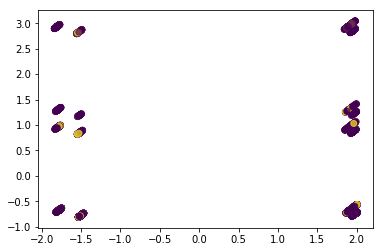

In [81]:
from sklearn.preprocessing import StandardScaler
# Scale the features using z-score
scl = StandardScaler()
X_scaled = scl.fit_transform(x)
pca = PCA()
X_fit_trans = pca.fit_transform(X_scaled)
plt.scatter(X_fit_trans[:, 0], X_fit_trans[:, 1], c=y, alpha=0.7)
plt.show()

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_fit_trans, y, 
                 test_size=0.3, 
                 stratify=None, ## Change this
                 random_state=42)

print('Before spliting:')
print(X_fit_trans.shape, y.shape, y.sum()/y.shape[0])

print('After spliting:')
print(X_train.shape, y_train.shape, y_train.sum()/y_train.shape[0])
print(X_test.shape, y_test.shape, y_test.sum()/y_test.shape[0])

Before spliting:
(12000, 11) (12000,) 0.111
After spliting:
(8400, 11) (8400,) 0.11095238095238096
(3600, 11) (3600,) 0.1111111111111111
